In [1]:
import torch
from torchtext import data
import re
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF
from torchvision.datasets import MNIST
from skimage import io, transform
import random

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from seglearn.transform import InterpLongToWide, SegmentX, FeatureRep, PadTrunc
from seglearn.pipe import Pype
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold, train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [3]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


## Experimenting with other timeseries classifiers

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import _LRScheduler

In [5]:
# DATALOADING
class ExerciseDataset(Dataset):
    """Shoulder exercise dataset"""
    
    def __init__(self, npy_file, length=None, transform=None, sanity_check=None):
        self.dataset = np.load(npy_file, allow_pickle=True).item()
        self.seq_length = length
        self.data = self.process_dataset(length)
        self.original_data = self.data.copy()
        self.data = self.data.astype(np.float)
        self.targets = self.dataset['exnum']
        self.targets = self.targets.reshape((self.targets.shape[0],))
        self.original_targets = self.targets.copy()
#         self.subject = self.dataset['subject']
#         self.original_subject = self.subject.copy()
        
        self.transform = transform
        
        if sanity_check is not None:
            self.data = [self.data[sanity_check]]
            self.targets = [self.targets[sanity_check]]

        assert (len(self.data) == len(self.targets))
        
    def process_dataset(self, length):
        shape = [data.shape[0] for data in self.dataset['X']]
        if length is None:
            average_len = round(sum(shape) / len(shape))
            self.seq_length = average_len
        processed, _, _ = PadTrunc(width=self.seq_length).transform(X=self.dataset['X'])
        return processed
    
    def fold(self, fold_indices):
        # Create fold for K-fold validation
        self.data = self.original_data[fold_indices]
        self.targets = self.original_targets[fold_indices]
#         self.subject = self.original_subject[fold_indices]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        return torch.from_numpy(self.data[idx]), self.targets[idx]

In [6]:
dataset = ExerciseDataset("combined_data.npy", length=200)

In [7]:
dataset[0][1]

5

In [8]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
assert train_size + test_size == len(dataset)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [9]:
WORKERS=6
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=WORKERS, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=4, num_workers=WORKERS, shuffle=False, drop_last=True)

In [10]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
#         self.fc1 = nn.Linear(hidden_dim, 100)
#         self.fc2 = nn.Linear(100, output_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.dropout(out)
#         out = F.relu(self.fc1(out))
#         out = F.softmax(self.fc2(out[:, -1, :]), dim=1)
        out = self.fc2(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]



In [11]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [12]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

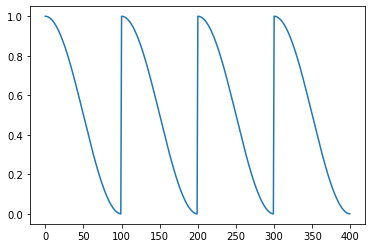

In [13]:
n = 100
sched = cosine(n)
lrs = [sched(t, 1) for t in range(n * 4)]
plt.plot(lrs)

In [14]:
#Model
input_dim = 3
hidden_dim = 128
layer_dim = 3
output_dim = 9 # 9 classes
seq_dim = dataset.seq_length

# iterations_per_epoch = len(train_loader)
best_acc = 0
patience, trials = 100, 0

In [15]:
model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim, 0.5)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
criterion = criterion.cuda()
# opt = torch.optim.RMSprop(model.parameters(), lr=lr)
opt = torch.optim.Adam(model.parameters())
# sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

In [16]:
def training(train_loader, net, optimizer, criterion, loss_graph, acc_graph):
    
    epoch_loss = 0
    epoch_acc = 0
    net.train()
#     denom = len(train_loader.dataset) // train_loader.batch_size
    
    for i, batch in enumerate(train_loader):
        
        opt.zero_grad()
        x_batch, y_batch = batch
        x_batch = x_batch.float().cuda()
        y_batch = y_batch.long().cuda()
        
        out = model(x_batch)
        
        # Accuracy
        preds = F.softmax(out, dim=1).argmax(dim=1)
        correct = (preds == y_batch)
        acc = correct.sum().item() / len(correct)
        acc_graph.append(100*acc)
        
        # Loss
        loss = criterion(out, y_batch)
        loss_graph.append(loss.item())
        loss.backward()
        opt.step()
#         sched.step()

        epoch_loss += loss.item()
        epoch_acc += acc

    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)
#     return epoch_loss / denom, epoch_acc / denom


def evaluate(val_loader, net, criterion, loss_graph, acc_graph):
    
    epoch_loss = 0
    epoch_acc = 0
    net.eval()
    
#     denom = len(val_loader.dataset) // val_loader.batch_size
    
    with torch.no_grad():
        for i, val in enumerate(val_loader):
            x_val, y_val = val
            x_val = x_val.float().cuda()
            y_val = y_val.long().cuda()
    
            out = model(x_val)
        
            # Accuracy
            preds = F.softmax(out, dim=1).argmax(dim=1)
            correct = (preds == y_val)
            acc = correct.sum().item() / len(correct)
            acc_graph.append(100*acc)
            
            # Loss
            loss = criterion(out, y_val)
            loss_graph.append(loss.item())
              
            epoch_loss += loss.item()
            epoch_acc += acc

    return epoch_loss / len(val_loader), epoch_acc / len(val_loader)
#     return epoch_loss / denom, epoch_acc / denom

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.05 µs


<IPython.core.display.Javascript object>


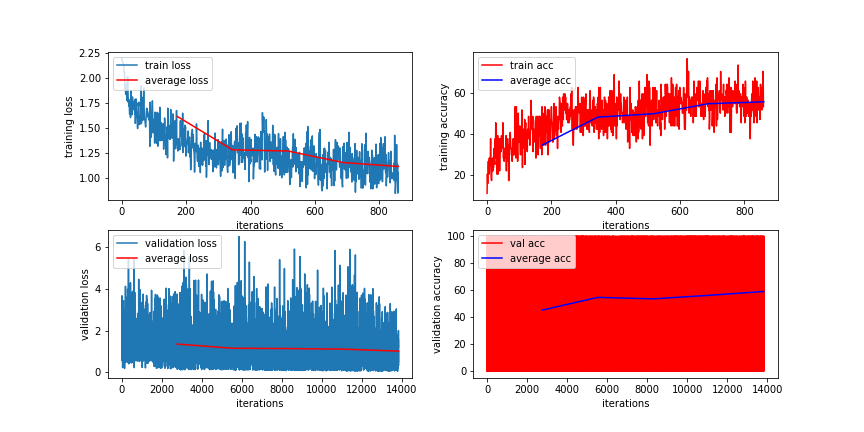

Split 0
Epoch 0 best model saved with accuracy: 38.51%
Epoch 1 best model saved with accuracy: 47.13%
Epoch 3 best model saved with accuracy: 51.71%
Epoch 4 best model saved with accuracy: 55.35%
Epoch 5 best model saved with accuracy: 55.65%
Epoch 8 best model saved with accuracy: 58.66%
Epoch 10 best model saved with accuracy: 60.03%
Epoch 11 best model saved with accuracy: 62.30%
Epoch 16 best model saved with accuracy: 66.15%
Epoch 18 best model saved with accuracy: 66.73%
Epoch 20 best model saved with accuracy: 67.27%
Epoch 23 best model saved with accuracy: 70.52%
Epoch 29 best model saved with accuracy: 72.94%
Epoch 33 best model saved with accuracy: 73.77%
Epoch 36 best model saved with accuracy: 74.35%
Epoch 37 best model saved with accuracy: 75.83%
Epoch 39 best model saved with accuracy: 77.33%
Epoch 40 best model saved with accuracy: 77.82%
Epoch 43 best model saved with accuracy: 78.71%
Epoch 47 best model saved with accuracy: 79.18%
Epoch 48 best model saved with accurac

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


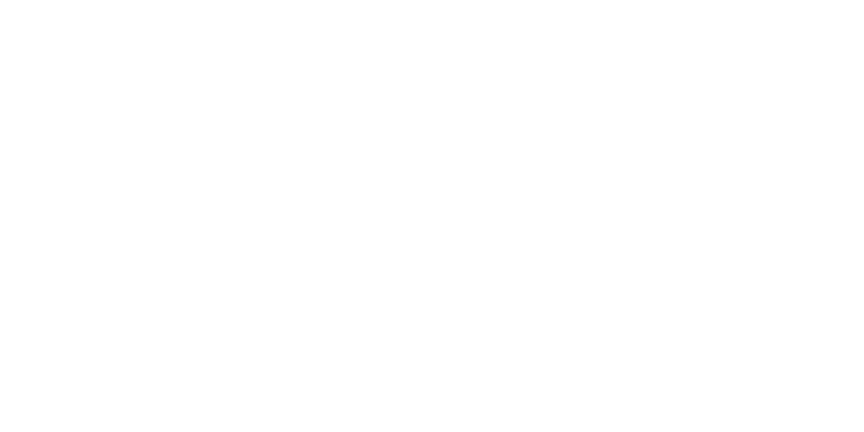

In [17]:
%time
%matplotlib notebook

N_EPOCHS = 60

loss_graph_train = []
avg_loss_train = []
acc_graph_train = []
avg_acc_train = []
loss_graph_val = []
avg_loss_val = []
acc_graph_val = []
avg_acc_val = []

fig = plt.figure(figsize=(12,6))
fig.tight_layout()

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

# Group patients in distinct folds vs stratified K fold
# gkf = GroupKFold(n_splits=5)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=26)
splits = skf.split(dataset.data, dataset.targets)
for i, (train, test) in enumerate(splits):
    # Model 
    model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim, 0.5)
    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.cuda()
    opt = torch.optim.Adam(model.parameters())

    # Training
    print("Split {}".format(i))
    filename = 'best_skf' + str(i)
    dataset.fold(train)
    train_loader = DataLoader(dataset, batch_size=64, num_workers=WORKERS, shuffle=True, drop_last=True)
    dataset.fold(test)
    test_loader = DataLoader(dataset, batch_size=4, num_workers=WORKERS, shuffle=False, drop_last=True)
    for epoch in range(N_EPOCHS):
        
        train_loss, train_acc = training(train_loader, model, opt, criterion, loss_graph_train, acc_graph_train)  
        val_loss, val_acc = evaluate(test_loader, model, criterion, loss_graph_val, acc_graph_val)

        # Saving best model and early stopping
        if val_acc > best_acc:
            trials = 0
            best_acc = val_acc
            torch.save(model.state_dict(), filename + ".pth")
            print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
        else:
            trials += 1
            if trials >= patience:
                print(f'Early stopping on epoch {epoch}')
                trials = 0
    #             break

        avg_loss_train.append((len(loss_graph_train), train_loss))
        avg_acc_train.append((len(acc_graph_train), train_acc*100.))

        avg_loss_val.append((len(loss_graph_val), val_loss))
        avg_acc_val.append((len(acc_graph_val), val_acc*100.))

        # TRAINING
        ax1.clear()
        ax1.set_xlabel('iterations')
        ax1.set_ylabel('training loss')
        ax1.plot(loss_graph_train, label='train loss')
        ax1.plot(*zip(*avg_loss_train), label="average loss", color='red')
        ax1.legend(loc='upper left')
        
        ax2.clear()
        ax2.set_ylabel('training accuracy')
        ax2.set_xlabel('iterations')
        ax2.plot(acc_graph_train, label='train acc', color='red')
        ax2.plot(*zip(*avg_acc_train), label="average acc", color='blue')
        ax2.legend(loc='upper left')

        # EVALUATION
        ax3.clear()
        ax3.set_xlabel('iterations')
        ax3.set_ylabel('validation loss')
        ax3.plot(loss_graph_val, label='validation loss')
        ax3.plot(*zip(*avg_loss_val), label="average loss", color='red')
        ax3.legend(loc='upper left') 
        
        ax4.clear()
        ax4.set_ylabel('validation accuracy')
        ax4.set_xlabel('iterations')
        ax4.plot(acc_graph_val, label='val acc', color='red')
        ax4.plot(*zip(*avg_acc_val), label="average acc", color='blue')
        ax4.legend(loc='upper left')
        fig.canvas.draw()
    # Reset
    loss_graph_train = []
    avg_loss_train = []
    acc_graph_train = []
    avg_acc_train = []
    loss_graph_val = []
    avg_loss_val = []
    acc_graph_val = []
    avg_acc_val = []
    
    best_acc = 0
    patience, trials = 100, 0

In [ ]:
# train_loader.batch_size

In [ ]:
# %time
# %matplotlib notebook

# N_EPOCHS = 60

# loss_graph_train = []
# avg_loss_train = []
# acc_graph_train = []
# avg_acc_train = []
# loss_graph_val = []
# avg_loss_val = []
# acc_graph_val = []
# avg_acc_val = []

# fig = plt.figure(figsize=(12,6))
# fig.tight_layout()

# ax1 = fig.add_subplot(2,2,1)
# ax2 = fig.add_subplot(2,2,2)
# ax3 = fig.add_subplot(2,2,3)
# ax4 = fig.add_subplot(2,2,4)

# for epoch in range(N_EPOCHS):
    
#     train_loss, train_acc = training(train_loader, model, opt, criterion, loss_graph_train, acc_graph_train)  
#     val_loss, val_acc = evaluate(test_loader, model, criterion, loss_graph_val, acc_graph_val)
    
#     # Saving best model and early stopping
#     if val_acc > best_acc:
#         trials = 0
#         best_acc = val_acc
#         torch.save(model.state_dict(), 'best.pth')
#         print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
#     else:
#         trials += 1
#         if trials >= patience:
#             print(f'Early stopping on epoch {epoch}')
#             trials = 0
# #             break
       
#     avg_loss_train.append((len(loss_graph_train), train_loss))
#     avg_acc_train.append((len(acc_graph_train), train_acc*100.))
    
#     avg_loss_val.append((len(loss_graph_val), val_loss))
#     avg_acc_val.append((len(acc_graph_val), val_acc*100.))
    
#     # TRAINING
#     ax1.clear()
#     ax1.set_xlabel('iterations')
#     ax1.set_ylabel('training loss')
#     ax1.plot(loss_graph_train, label='train loss')
#     ax1.plot(*zip(*avg_loss_train), label="average loss", color='red')
#     ax1.legend(loc='upper left')
    
#     ax2.set_ylabel('training accuracy')
#     ax2.set_xlabel('iterations')
#     ax2.plot(acc_graph_train, label='train acc', color='red')
#     ax2.plot(*zip(*avg_acc_train), label="average accuracy", color='blue')
    
#     # EVALUATION
#     ax3.clear()
#     ax3.set_xlabel('iterations')
#     ax3.set_ylabel('validation loss')
#     ax3.plot(loss_graph_val, label='validation loss')
#     ax3.plot(*zip(*avg_loss_val), label="average loss", color='red')
#     ax3.legend(loc='upper left') 

#     ax4.set_ylabel('validation accuracy')
#     ax4.set_xlabel('iterations')
#     ax4.plot(acc_graph_val, label='val acc', color='red')
#     ax4.plot(*zip(*avg_acc_val), label="average accuracy", color='blue')
#     fig.canvas.draw()

In [ ]:
#END

In [19]:
len(test_dataset.dataset)


11067